In [193]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
#!pip install pandas
#!pip install tqdm

#!pip install scipy
#!pip install matchms
#!pip install scikit-learn
#!pip install spec2vec
#!pip install seaborn

In [195]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [196]:
from src.transformers.sklearn_model import SklearnModel

In [197]:
import gensim
from src.load_data import LoadData
from src.config import Config
from matchms import calculate_scores
from matchms.importing import load_from_mgf,load_from_msp
import matchms.filtering as msfilters
from spec2vec import SpectrumDocument
from torch.utils.data import DataLoader, WeightedRandomSampler
from spec2vec.model_building import train_new_word2vec_model
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
from pytorch_lightning.callbacks import ProgressBar
from src.losscallback import LossCallback
import numpy as np
from matchms.importing import load_from_msp
from matchms.similarity import ModifiedCosine
from scipy.stats import spearmanr
import dill
from src.weight_sampling import WeightSampling
from src.plotting import Plotting
from torch.utils.data import DataLoader, WeightedRandomSampler
import lightning.pytorch as pl
from src.load_data import LoadData
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
from matchms.filtering import add_fingerprint
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.spec2vec_comparison import Spec2VecComparison
from src.ms2deepscore_comparison import MS2DeepScoreComparison
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr
from src.transformers.load_data import LoadData as LoadDataTrans

In [198]:
from src.transformers.embedder import Embedder

In [199]:
ls /Users/sebas/projects/data

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
best_model_128n_5_layers_20240229.ckpt
best_model_128n_5_layers_20240303.ckpt
best_model_20240301.ckpt
drug_plus.mgf
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl
merged_gnps_nist_20240227_gnps_nist_janssen_20_millions_OUTSIDE_MAX_DIFF_NO_JANSSEN.pkl
ms2deepscore_positive_10k_1000_1000_1000_500.hdf5
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.wv.vectors.npy
to_export_gnps_nist.pkl
uniformed_molecule_pairs_test.pkl


## Parameters

In [200]:
data_folder= '/Users/sebas/projects/data/'
dataset_path = data_folder + 'uniformed_molecule_pairs_test.pkl'
gnps_path =  data_folder + 'ALL_GNPS_NO_PROPOGATED_wb.mgf'
janssen_path = data_folder + 'drug_plus.mgf'
nist_path = data_folder + 'hr_msms_nist_all.MSP'
output_pairs_file= data_folder + 'molecular_pairs.pkl'
output_nist_file= data_folder + 'all_spectrums_nist.pkl'
output_gnps_file= data_folder + 'all_spectrums_gnps.pkl'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'
model_ms2d_file= data_folder + 'ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'
#uniformed_molecule_pairs_test_path= data_folder +'uniformed_molecule_pairs_test.pkl'
uniformed_molecule_pairs_test_path= data_folder +'merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl'
transformer_path = data_folder + 'best_model_128n_5_layers_20240219_elementwise.ckpt'

In [201]:
THRESHOLD_ANALOG=0.7

In [202]:
load_molecule_pairs_file= True
only_use_gnps=False

In [203]:
## Load spectrum using spectrumutils

In [204]:
config=Config()

In [205]:
config.CHECKPOINT_DIR = './notebooks/cosine/results'
config.use_cosine_distance=True

In [206]:
NUMBER_TRAIN_PAIRS=10000

## Load molecular pairs

In [207]:

if load_molecule_pairs_file:
        with open(uniformed_molecule_pairs_test_path, 'rb') as file:
            dataset = dill.load(file)


In [208]:
molecule_pairs_train= dataset['molecule_pairs_train']
molecule_pairs_val= dataset['molecule_pairs_val']

## Our model

In [209]:
from src.transformers.sklearn_model import SklearnModel

In [210]:
# Generate an array of 10 random integers between 0 and 100
random_integers_train = np.random.randint(0, len(molecule_pairs_train), NUMBER_TRAIN_PAIRS)
random_integers_val = np.random.randint(0, len(molecule_pairs_val), NUMBER_TRAIN_PAIRS)

In [211]:
molecule_pairs_train= MolecularPairsSet(spectrums= molecule_pairs_train.spectrums, 
                                      indexes_tani =molecule_pairs_train.indexes_tani[random_integers_train])
molecule_pairs_val= MolecularPairsSet(spectrums= molecule_pairs_val.spectrums, 
                                      indexes_tani =molecule_pairs_val.indexes_tani[random_integers_val])

In [212]:
## CALCULATION OF WEIGHTS
train_binned_list, _ = TrainUtils.divide_data_into_bins(
    molecule_pairs_train, config.bins_uniformise_TRAINING,
)

In [213]:
weights, range_weights = WeightSampling.compute_weights(train_binned_list)

In [214]:
weights

array([0.02769504, 0.01135994, 0.01793957, 0.04437684, 0.12440065,
       0.01573821, 0.05532277, 0.16437054, 0.22428886, 0.26017508,
       0.0543325 ])

In [215]:
range_weights

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [216]:
weights_tr = WeightSampling.compute_sample_weights(molecule_pairs_train, weights)
weights_val = WeightSampling.compute_sample_weights(molecule_pairs_val, weights)

In [217]:
dataset_train = LoadDataTrans.from_molecule_pairs_to_dataset(molecule_pairs_train, training=True)
# dataset_test = LoadData.from_molecule_pairs_to_dataset(m_test)
dataset_val = LoadDataTrans.from_molecule_pairs_to_dataset(molecule_pairs_val)

Preprocessing all the data ...



0it [00:00, ?it/s]
9246it [00:00, 92452.37it/s]
18620it [00:00, 93208.26it/s]
27941it [00:00, 92468.80it/s]
37189it [00:00, 91971.67it/s]
46387it [00:00, 91505.91it/s]
55539it [00:00, 90875.98it/s]
64628it [00:00, 90261.13it/s]
73655it [00:00, 89914.46it/s]
82647it [00:00, 89019.33it/s]
91551it [00:01, 88635.00it/s]
100416it [00:01, 88005.50it/s]
109218it [00:01, 87712.54it/s]
117990it [00:01, 86964.45it/s]
126688it [00:01, 85546.07it/s]
135247it [00:01, 84751.89it/s]
143725it [00:01, 82937.02it/s]
152026it [00:01, 81585.62it/s]
160191it [00:01, 81103.27it/s]
168305it [00:01, 78999.41it/s]
176215it [00:02, 77238.95it/s]
183949it [00:02, 76241.16it/s]
191579it [00:02, 75110.66it/s]
199094it [00:02, 73600.08it/s]
206458it [00:02, 72046.36it/s]
213667it [00:02, 71804.88it/s]
220850it [00:02, 70104.95it/s]
227866it [00:02, 67565.67it/s]
234638it [00:02, 65581.08it/s]
241210it [00:03, 63568.40it/s]
247580it [00:03, 61480.76it/s]
253741it [00:03, 58317.31it/s]
263328it [00:03, 77013.56it/s]

Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries
Preprocessing all the data ...



0it [00:00, ?it/s]
8972it [00:00, 89715.59it/s]
17944it [00:00, 87376.98it/s]
32605it [00:00, 76840.38it/s]

Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries


In [218]:
train_sampler = WeightedRandomSampler(
    weights=weights_tr, num_samples=len(dataset_train), replacement=True
)
val_sampler = WeightedRandomSampler(
    weights=weights_val, num_samples=len(dataset_val), replacement=True
)


In [219]:
dataloader_train = DataLoader(
    dataset_train, batch_size=config.BATCH_SIZE,  num_workers=10, sampler=train_sampler,
)
def worker_init_fn(
    worker_id,
):  # ensure the dataloader for validation is the same for every epoch
    seed = 42
    torch.manual_seed(seed)
    # Set the same seed for reproducibility in NumPy and Python's random module
    np.random.seed(seed)
    random.seed(seed)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=config.BATCH_SIZE,
    num_workers=0,
    sampler=val_sampler,
)


In [220]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=config.CHECKPOINT_DIR,
    filename="best_model",
    monitor="validation_loss_epoch",
    mode="min",
    save_top_k=1,
)

# checkpoint_callback = SaveBestModelCallback(file_path=config.best_model_path)
progress_bar_callback = ProgressBar()

# loss callback
losscallback = LossCallback(file_path=config.CHECKPOINT_DIR + f"loss.png")

print("define model")


    
model = Embedder(
        d_model=int(config.D_MODEL),
        n_layers=int(config.N_LAYERS),
        weights=None,
        lr=config.LR,
        use_cosine_distance=config.use_cosine_distance,
    )

define model


In [221]:
config.LR

0.0001

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                    | Type                             | Params
-----------------------------------------------------------------------------
0 | linear                  | Linear                           | 16.5 K
1 | linear_regression       | Linear                           | 129   
2 | fixed_linear_regression | FixedLinearRegression            | 129   
3 | relu                    | ReLU                             | 0     
4 | spectrum_encoder        | SpectrumTransformerEncoderCustom | 1.7 M 
5 | linear_pre_embedding_1  | Linear                           | 16.5 K
6 | linear_pre_embedding_2  | Linear                           | 16.5 K
7 | regression_loss         | MSELoss                          | 0     
8 | dropout                 | Dropout                          | 0     
9 | linear_cosine           | Linear              

Sanity Checking: |                                                                                            …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss:
[]
Validation loss
[0.24656084179878235]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.24656084179878235, 0.10005910694599152]


Validation: |                                                                                                 …

Train loss:
[0.08342190831899643]
Validation loss
[0.24656084179878235, 0.10005910694599152, 0.10716643184423447]


Validation: |                                                                                                 …

Train loss:
[0.08342190831899643, 0.06893588602542877]
Validation loss
[0.24656084179878235, 0.10005910694599152, 0.10716643184423447, 0.0921931192278862]


Validation: |                                                                                                 …

Train loss:
[0.08342190831899643, 0.06893588602542877, 0.059279877692461014]
Validation loss
[0.24656084179878235, 0.10005910694599152, 0.10716643184423447, 0.0921931192278862, 0.08618830144405365]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11875df80>
Traceback (most recent call last):
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/connection.py", line 947, in wait
    ready = selector.

Error in callback <bound method AutoreloadMagics.post_execute_hook of <IPython.extensions.autoreload.AutoreloadMagics object at 0x1038de690>> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: DataLoader worker (pid 9449) is killed by signal: Interrupt: 2. 

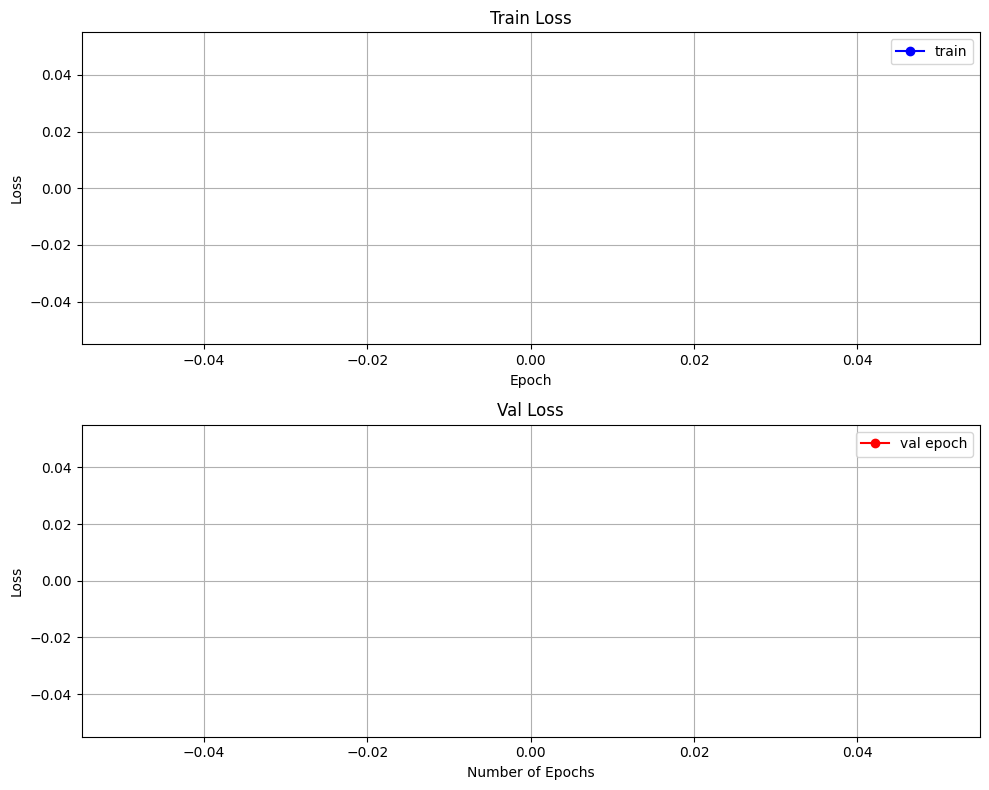

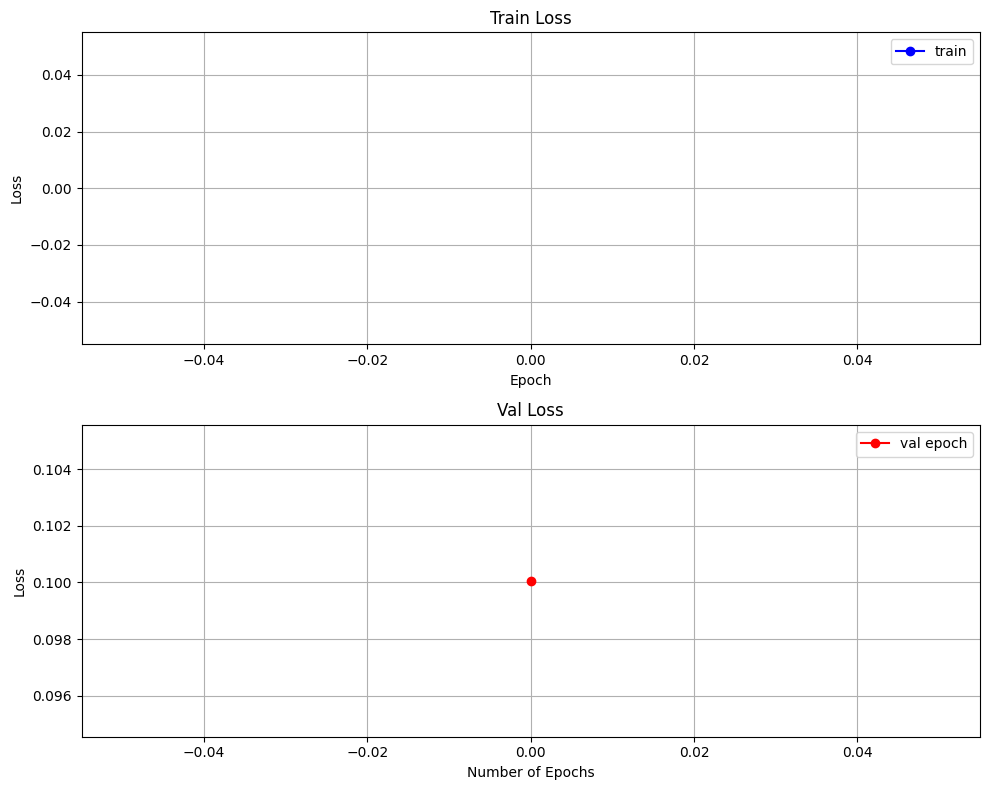

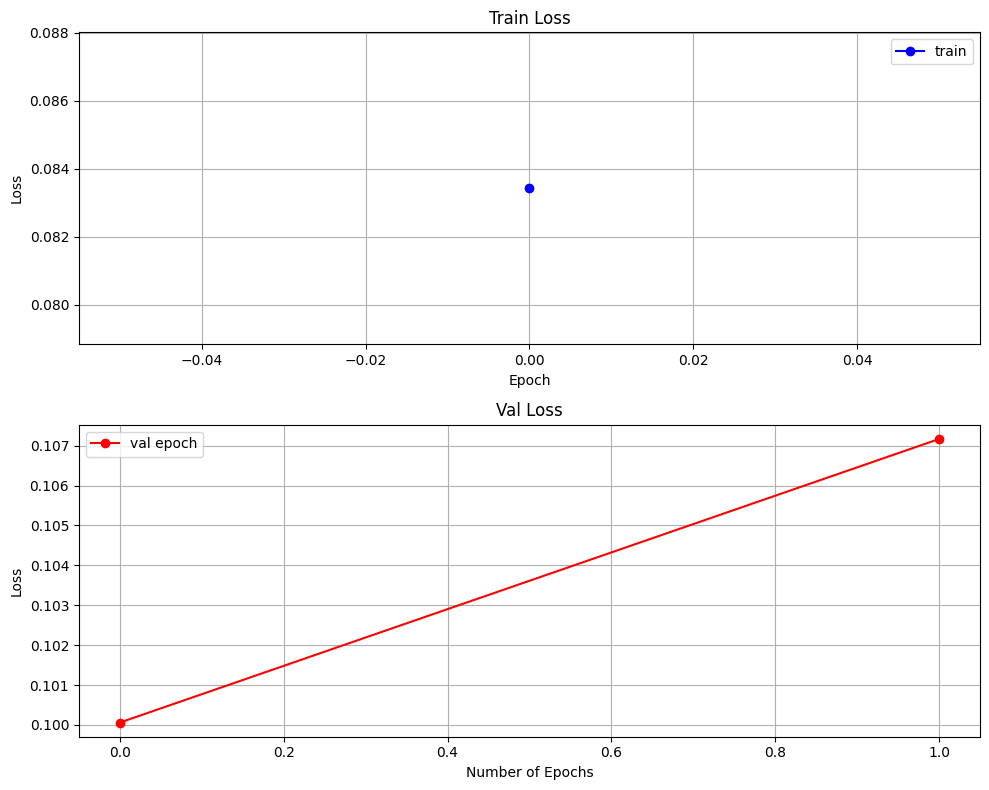

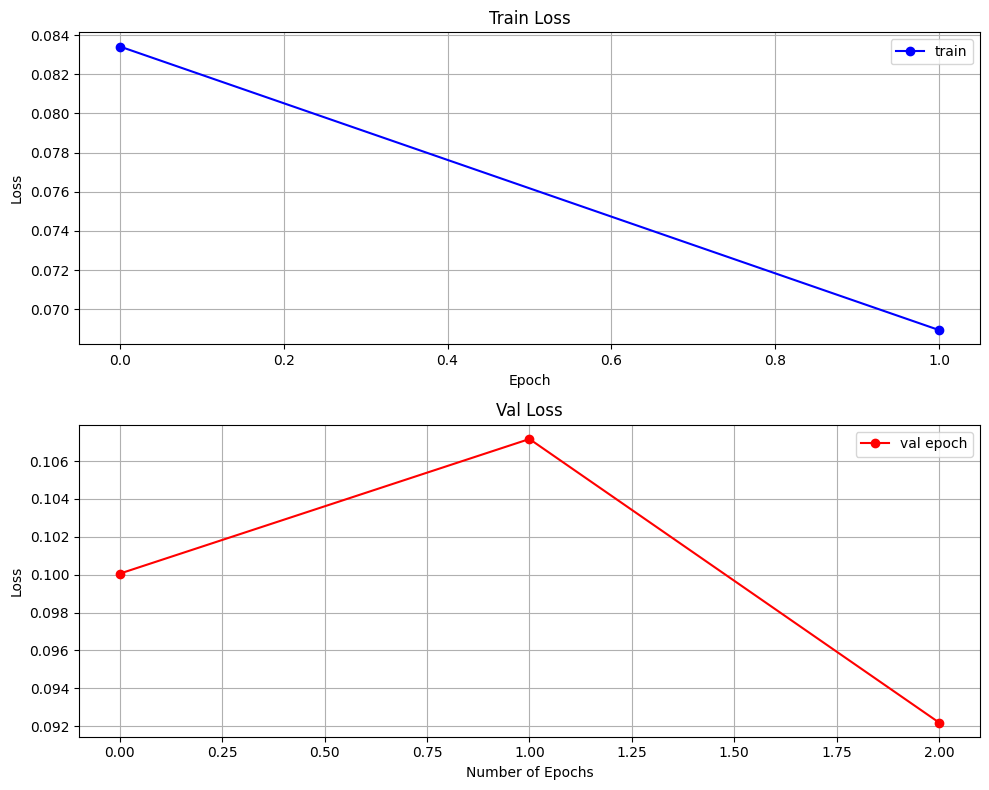

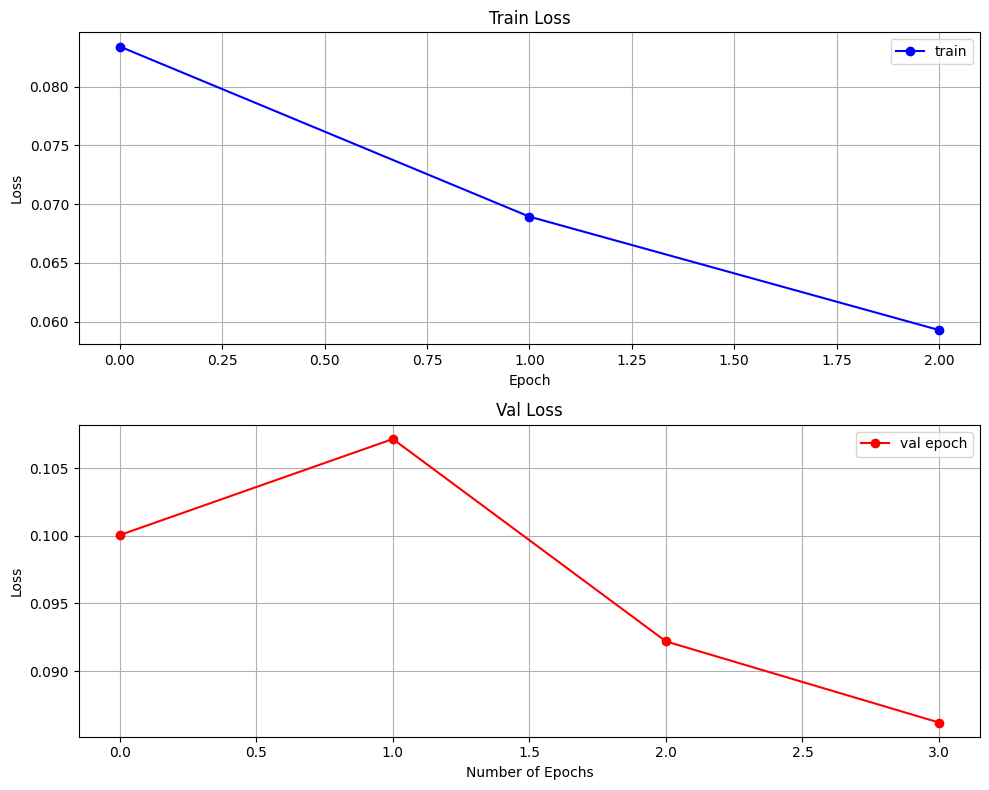

In [222]:
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[checkpoint_callback, losscallback],
    enable_progress_bar=True,
    # val_check_interval= config.validate_after_ratio,
)
# trainer = pl.Trainer(max_steps=100,  callbacks=[checkpoint_callback, losscallback], enable_progress_bar=enable_progress_bar)
trainer.fit(
    model=model,
    train_dataloaders=(dataloader_train),
    val_dataloaders=dataloader_val,
)

In [223]:
for name, param in model.named_parameters():
    print(name)
    print(param)

linear.weight
Parameter containing:
tensor([[-0.0492,  0.0243, -0.0576,  ...,  0.0390,  0.0522,  0.0611],
        [-0.0184, -0.0850,  0.0465,  ...,  0.0085,  0.0742,  0.0678],
        [ 0.0292, -0.0595,  0.0238,  ...,  0.0046, -0.0662, -0.0856],
        ...,
        [ 0.0065, -0.0201, -0.0008,  ...,  0.0823, -0.0761, -0.0486],
        [ 0.0290,  0.0261, -0.0290,  ..., -0.0728,  0.0279, -0.0377],
        [ 0.0687,  0.0225, -0.0077,  ...,  0.0027, -0.0805, -0.0543]],
       device='mps:0', requires_grad=True)
linear.bias
Parameter containing:
tensor([-0.0811,  0.0359,  0.0518, -0.0177, -0.0285, -0.0437,  0.0276, -0.0569,
        -0.0602,  0.0125, -0.0412,  0.0857,  0.0147, -0.0057, -0.0012,  0.0460,
         0.0304,  0.0419, -0.0873,  0.0627, -0.0681,  0.0296,  0.0753, -0.0741,
        -0.0580,  0.0608,  0.0641,  0.0457, -0.0706, -0.0685,  0.0194,  0.0114,
        -0.0107, -0.0169,  0.0184, -0.0601,  0.0623,  0.0267,  0.0715, -0.0738,
        -0.0100,  0.0267,  0.0375,  0.0125, -0.0139, 